In [1]:
!pip install xgboost scikit-learn pyspark

import xgboost as xgb
from pyspark.sql import SparkSession
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
spark = SparkSession.builder \
    .appName("ChurnGuard-XGBoost") \
    .getOrCreate()

df = spark.read.parquet("./data/processed_features.parquet")
print(f"Loaded {df.count()} rows with {len(df.columns)} columns")
df.show(5)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/10 23:09:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Loaded 7043 rows with 3 columns
+----------+--------------------+-----+
|customerid|            features|label|
+----------+--------------------+-----+
|7590-VHVEG|(54,[1,3,4,7,10,1...|    0|
|5575-GNVDE|(54,[0,2,4,6,8,12...|    0|
|3668-QPYBK|(54,[0,2,4,6,8,12...|    1|
|7795-CFOCW|(54,[0,2,4,7,10,1...|    0|
|9237-HQITU|(54,[1,2,4,6,8,11...|    1|
+----------+--------------------+-----+
only showing top 5 rows


In [ ]:
df_pandas = df.toPandas()

X = np.array([x.toArray() for x in df_pandas['features']])
y = df_pandas['label'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Label distribution:\n{pd.Series(y).value_counts()}")

Feature matrix shape: (7043, 54)
Label distribution:
0    5174
1    1869
Name: count, dtype: int64


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (5634, 54)
Test set: (1409, 54)


In [5]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight (for class balance): {scale_pos_weight:.2f}")

Scale pos weight (for class balance): 2.77


In [ ]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42,
    early_stopping_rounds=20
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=10
)

print("✅ Model training complete!")

[0]	validation_0-logloss:0.65484	validation_1-logloss:0.65885
[10]	validation_0-logloss:0.48232	validation_1-logloss:0.52016
[20]	validation_0-logloss:0.42742	validation_1-logloss:0.49172
[30]	validation_0-logloss:0.40082	validation_1-logloss:0.48511
[40]	validation_0-logloss:0.38267	validation_1-logloss:0.48260
[50]	validation_0-logloss:0.36884	validation_1-logloss:0.48222
[60]	validation_0-logloss:0.35671	validation_1-logloss:0.48107
[70]	validation_0-logloss:0.34669	validation_1-logloss:0.47914
[80]	validation_0-logloss:0.33588	validation_1-logloss:0.48006
[89]	validation_0-logloss:0.32920	validation_1-logloss:0.48135
✅ Model training complete!


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 3, 5]
}

xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

grid_search = GridSearchCV(
    xgb_base, 
    param_grid, 
    cv=3, 
    scoring='precision',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Best params: {grid_search.best_params_}")
print(f"Best precision: {grid_search.best_score_:.4f}")

# Use best model
xgb_model = grid_search.best_estimator_


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best params: {'learning_rate': 0.2, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 200}
Best precision: 0.5725


In [15]:
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("=" * 50)
print("MODEL PERFORMANCE METRICS")
print("=" * 50)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")  
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print("=" * 50)

MODEL PERFORMANCE METRICS
Accuracy:  0.7651
Precision: 0.5516
Recall:    0.6150
F1-Score:  0.5815
ROC-AUC:   0.8117


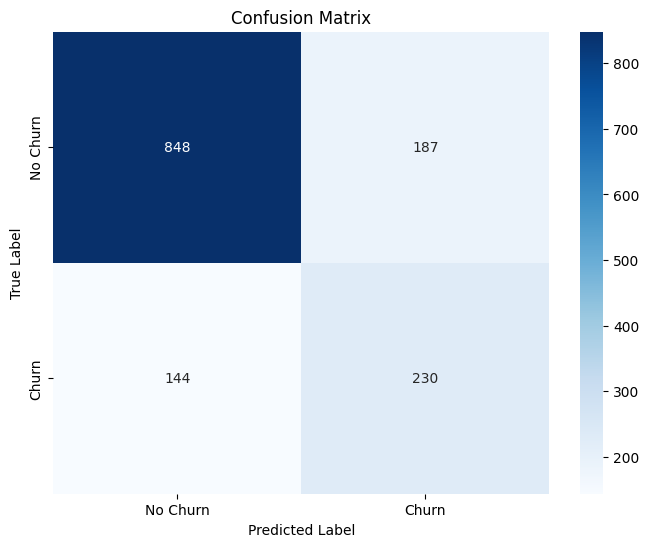

In [17]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

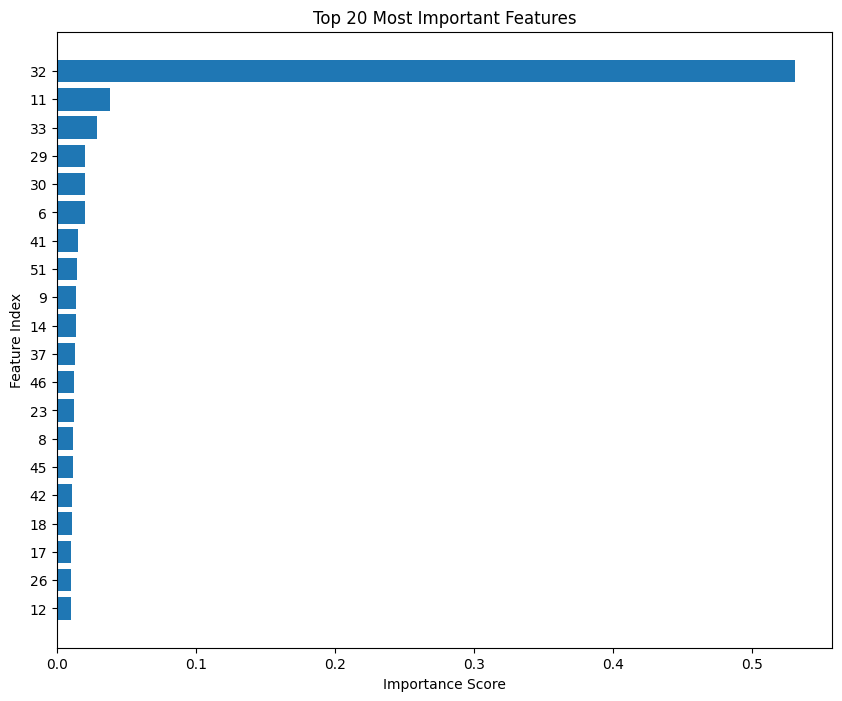

In [19]:
feature_importance = xgb_model.feature_importances_
importance_df = pd.DataFrame({
    'feature_index': range(len(feature_importance)),
    'importance': feature_importance
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature_index'].astype(str), importance_df['importance'])
plt.xlabel('Importance Score')
plt.ylabel('Feature Index')
plt.title('Top 20 Most Important Features')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import pickle
import os

os.makedirs('./results', exist_ok=True)

with open('./results/xgboost_churn_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

print("✅ Model saved to ./results/xgboost_churn_model.pkl")



✅ Model saved to ./results/xgboost_churn_model.pkl


In [21]:
sample_predictions = pd.DataFrame({
    'customer_id': df_pandas['customerid'].iloc[:10],
    'true_label': y[:10],
    'predicted_label': xgb_model.predict(X[:10]),
    'churn_probability': xgb_model.predict_proba(X[:10])[:, 1]
})

print("\nSample Predictions:")
print(sample_predictions)


Sample Predictions:
  customer_id  true_label  predicted_label  churn_probability
0  7590-VHVEG           0                0           0.177779
1  5575-GNVDE           0                0           0.002011
2  3668-QPYBK           1                1           0.897092
3  7795-CFOCW           0                0           0.022286
4  9237-HQITU           1                1           0.989104
5  9305-CDSKC           1                1           0.997873
6  1452-KIOVK           0                1           0.502233
7  6713-OKOMC           0                0           0.068935
8  7892-POOKP           1                1           0.941699
9  6388-TABGU           0                0           0.000619
